# Controls Analysis

### Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import iqr, norm
import statsmodels.stats.api as sms
import arch 
import pmdarima.arima as pm
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsap 
from statsmodels.tsa.stattools import adfuller

# Recursive OLS residuals
from statsmodels.stats.diagnostic import recursive_olsresiduals
from statsmodels.stats.diagnostic import breaks_cusumolsresid
import chow_test
from scipy import stats
import arch


from fredapi import Fred
fred = Fred(api_key='ca6ea25f72db47e2d070a76b7e9e639b')

import warnings
warnings.filterwarnings("ignore")
np.random.seed(432)

### Inflation - Guatemala

In [2]:
inf1 = pd.read_csv('output/inflation_SeasAdj.csv', delimiter=';')
inf1.index = pd.to_datetime(inf1.date)
inf1 = inf1.drop("date", axis = 1)
# inf1.head()

simdf = inf1.loc['1993-01-01':'2021-12-01']
predf = simdf.loc['1993-01-01':'2004-12-01']
itdf  = simdf.loc['2005-01-01':'2021-12-01']

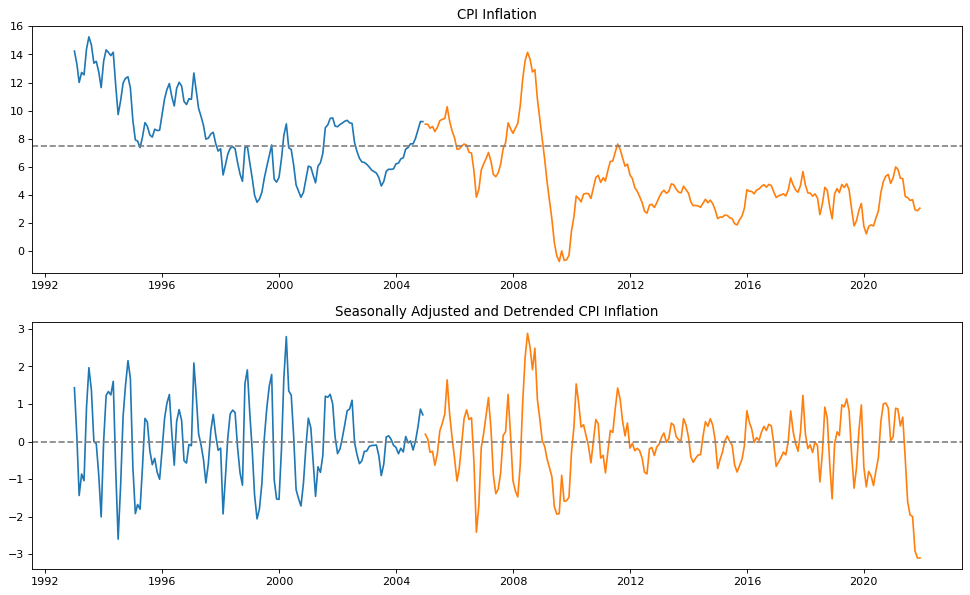

In [3]:
# Ploting the data
fig, axes = plt.subplots(2, 1, figsize=(15,9), dpi= 80)

axes[0].plot(predf['v_cpi'])
axes[0].plot(itdf['v_cpi'])
axes[0].set_title('CPI Inflation')
axes[0].axhline(y=np.mean(inf1['v_cpi']), color='grey', linestyle='--')

axes[1].plot(predf['inf_seasAdj'])
axes[1].plot(itdf['inf_seasAdj'])
axes[1].set_title('Seasonally Adjusted and Detrended CPI Inflation')
axes[1].axhline(y=0, color='grey', linestyle='--')

plt.show()


### Controls

Controls:
- **pce**:  Personal Consumption Expenditures: Chain-type Price Index (Source: BEA)
  - The Personal Consumption Expenditures Price Index is a measure of the prices that people living in the United States, or those buying on their behalf, pay for goods and services. The change in the PCE price index is known for capturing inflation (or deflation) across a wide range of consumer expenses and reflecting changes in consumer behavior. For example, if the price of beef rises, shoppers may buy less beef and more chicken.
- **core_pce**: Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index) (Source: BEA)
  - The Personal Consumption Expenditures Price Index is a measure of the prices that people living in the United States, or those buying on their behalf, pay for goods and services. The change in the PCE price index is known for capturing inflation (or deflation) across a wide range of consumer expenses and reflecting changes in consumer behavior. For example, if car prices rise, car sales may decline while bicycle sales increase.
- **cpiUS**:  Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (Source: BEA)
  - Price index of a basket of goods and services paid by urban consumers. Percent changes in the price index measure the inflation rate between any two time periods. The most common inflation metric is the percent change from one year ago. It can also represent the buying habits of urban consumers. This particular index includes roughly 88 percent of the total population, accounting for wage earners, clerical workers, technical workers, self-employed, short-term workers, unemployed, retirees, and those not in the labor force.
- **core_cpiUS**: Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average (Source: BEA)
  - The "Consumer Price Index for All Urban Consumers: All Items Less Food & Energy" is an aggregate of prices paid by urban consumers for a typical basket of goods, excluding food and energy. This measurement, known as "Core CPI," is widely used by economists because food and energy have very volatile prices.
- **gpenergy**: Global price of Energy index (Source: IMF)
  - Value represents the benchmark prices which are representative of the global market. They are determined by the largest exporter of a given commodity. Prices are period averages in nominal U.S. dollars.
- **pet**: WTI monthly Prices (Source: FRED)
  - Monthly West Texas Intermediate oil price series in FRED.
- **fao_Index**: FAO Food Price Index
  - Measure of the monthly change in international prices of a basket of food commodities. It consists of the average of five commodity group price indices weighted by the average export shares of each of the groups over 2014-2016.
- **food_imf**: IMF Food Index(Source: IMF)
  - Value represents the benchmark prices which are representative of the global market. They are determined by the largest exporter of a given commodity. Prices are period averages in nominal U.S. dollars.
- **IGREA**: Index of Global Real Economic Activity
  - This series is an updated index of global real economic activity in industrial commodity markets, as proposed in Kilian (2009), with the correction discussed in Kilian (2019). This business-cycle index is expressed in percent deviations from trend. It is derived from a panel of dollar-denominated global bulk dry cargo shipping rates and may be viewed as a proxy for the volume of shipping in global industrial commodity markets (Source: Federal Reserve Bank of Dallas)
- **USPHCI**: Coincident Economic Activity Index for the United States (Source: Federal Reserve Bank of Philadelphia)
  - The Coincident Economic Activity Index includes four indicators: nonfarm payroll employment, the unemployment rate, average hours worked in manufacturing and wages and salaries. The trend for each state's index is set to match the trend for gross state product.
- **imp_us**: Import Price Index (End Use): All Commodities (IR)
- **exp_us**: Export Price Index (End Use): All Commodities (IQ)


<!-- 
- ner_gt: Nominal Excchange Rate GT/USD
- omas_mn: montlhy Open Market Operations in GTQ
- emision: nominal money issuance in GTQ -->

### External Inflation

In [4]:
infE = pd.DataFrame()

# External Inflation
# PCE Inflation
infE['pce'] = fred.get_series('PCEPI').pct_change(12)*100
infE['core_pce'] = fred.get_series('PCEPILFE').pct_change(12)*100

# CPI Inflation
infE['cpiUS'] = fred.get_series('CPIAUCSL').pct_change(12)*100
infE['core_cpiUS'] = fred.get_series('CPILFESL').pct_change(12)*100

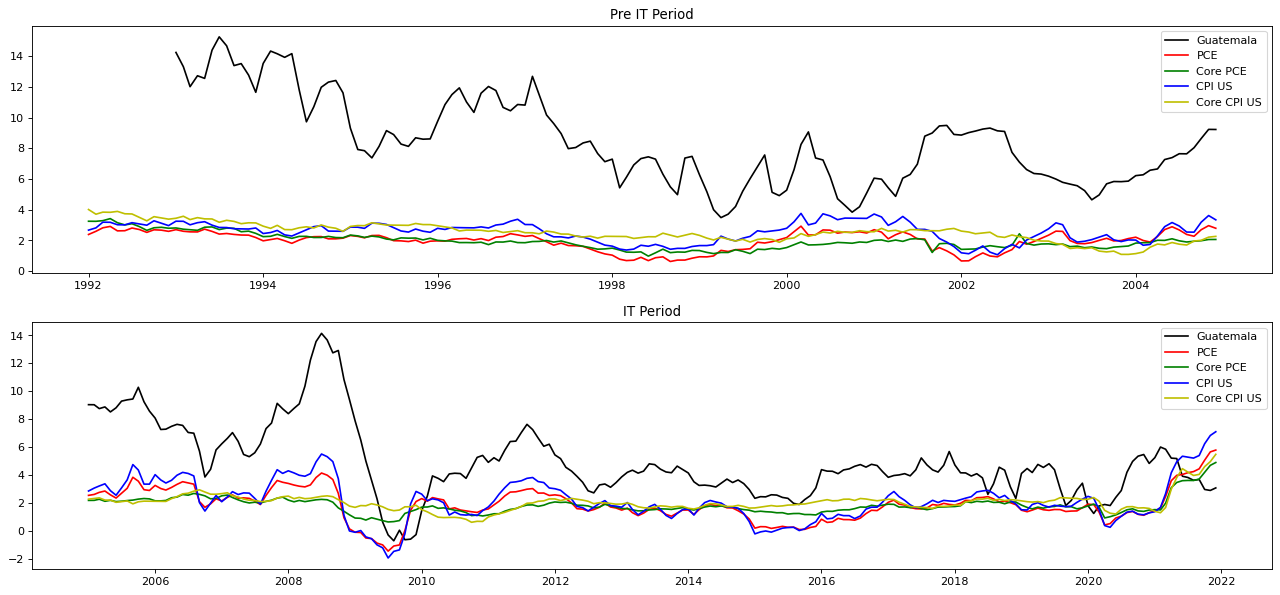

In [5]:
# plt.figure(figsize=(15,9), dpi= 80)

fig, axes = plt.subplots(2, 1, figsize=(20,9), dpi= 80)
axes[0].set_title('Pre IT Period')
axes[0].plot(simdf['v_cpi'].loc['1992-01-01':'2004-12-01'], color='k',label='Guatemala')
axes[0].plot(infE['pce'].loc['1992-01-01':'2004-12-01'], color='r',label='PCE')
axes[0].plot(infE['core_pce'].loc['1992-01-01':'2004-12-01'], color='g',label='Core PCE')
axes[0].plot(infE['cpiUS'].loc['1992-01-01':'2004-12-01'], color='b',label='CPI US')
axes[0].plot(infE['core_cpiUS'].loc['1992-01-01':'2004-12-01'], color='y',label='Core CPI US')
axes[0].legend()

axes[1].set_title('IT Period')
axes[1].plot(simdf['v_cpi'].loc['2005-01-01':'2021-12-01'], color='k',label='Guatemala')
axes[1].plot(infE['pce'].loc['2005-01-01':'2021-12-01'], color='r',label='PCE')
axes[1].plot(infE['core_pce'].loc['2005-01-01':'2021-12-01'], color='g',label='Core PCE')
axes[1].plot(infE['cpiUS'].loc['2005-01-01':'2021-12-01'], color='b',label='CPI US')
axes[1].plot(infE['core_cpiUS'].loc['2005-01-01':'2021-12-01'], color='y',label='Core CPI US')
axes[1].legend()

plt.show()

#### Correlation with Inflation Measures

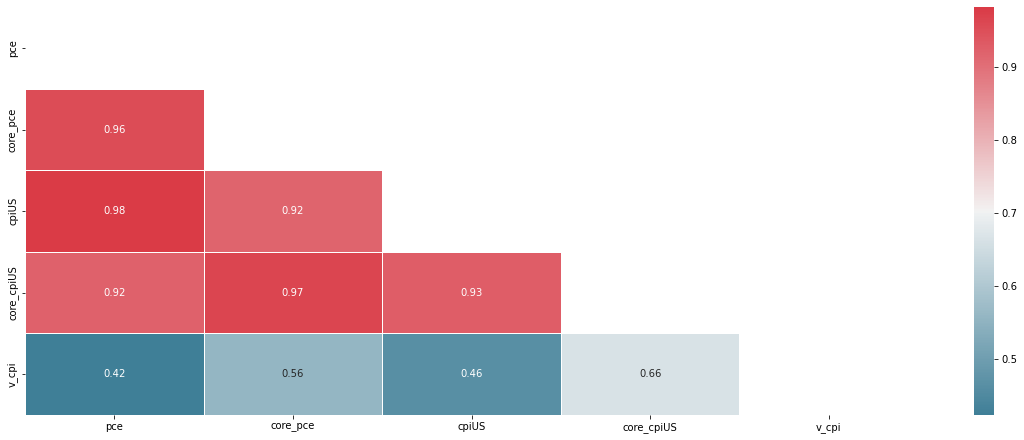

In [6]:
# Correlation matrix
corr_matrix = infE[['pce','core_pce','cpiUS','core_cpiUS' ]].copy()
# corr_matrix['inf_seasAdj'] = inf1['inf_seasAdj']
corr_matrix['v_cpi'] = inf1['v_cpi']
# Correlation Matrix for subset, region not included
corr = corr_matrix.corr()
fig, ax = plt.subplots(figsize=(20, 7.5))
colormap = sns.diverging_palette(225, 10, as_cmap = True)
dropvals = np.zeros_like(corr)
dropvals[np.triu_indices_from(dropvals)] = True
sns.heatmap(corr, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals)
plt.show()

#### Correlation with lags of different inflation measures

In [50]:
# lag creation
lags_inf = pd.DataFrame()
# PCE Inflation
lags_inf["pce_l1"] = infE['pce'].shift().loc['1993-01-01':]
lags_inf["pce_l3"] = infE['pce'].shift(3).loc['1993-01-01':]
lags_inf["pce_l6"] = infE['pce'].shift(6).loc['1993-01-01':]
lags_inf["pce_l9"] = infE['pce'].shift(9).loc['1993-01-01':]
lags_inf["pce_l12"] = infE['pce'].shift(12).loc['1993-01-01':]

# Core PCE Inflation
lags_inf["core_pce_l1"] = infE['core_pce'].shift().loc['1993-01-01':]
lags_inf["core_pce_l3"] = infE['core_pce'].shift(3).loc['1993-01-01':]
lags_inf["core_pce_l6"] = infE['core_pce'].shift(6).loc['1993-01-01':]
lags_inf["core_pce_l9"] = infE['core_pce'].shift(9).loc['1993-01-01':]
lags_inf["core_pce_l12"] = infE['core_pce'].shift(12).loc['1993-01-01':]

# CPI Inflation
lags_inf["cpiUS_l1"] = infE['cpiUS'].shift().loc['1993-01-01':]
lags_inf["cpiUS_l3"] = infE['cpiUS'].shift(3).loc['1993-01-01':]
lags_inf["cpiUS_l6"] = infE['cpiUS'].shift(6).loc['1993-01-01':]
lags_inf["cpiUS_l9"] = infE['cpiUS'].shift(9).loc['1993-01-01':]
lags_inf["cpiUS_l12"] = infE['cpiUS'].shift(12).loc['1993-01-01':]

# Core CPI Inflation
lags_inf["core_cpiUS_l1"] = infE['core_cpiUS'].shift().loc['1993-01-01':]
lags_inf["core_cpiUS_l3"] = infE['core_cpiUS'].shift(3).loc['1993-01-01':]
lags_inf["core_cpiUS_l6"] = infE['core_cpiUS'].shift(6).loc['1993-01-01':]
lags_inf["core_cpiUS_l9"] = infE['core_cpiUS'].shift(9).loc['1993-01-01':]
lags_inf["core_cpiUS_l12"] = infE['core_cpiUS'].shift(12).loc['1993-01-01':]

lags_inf = lags_inf.loc['1993-01-01':]
lags_inf['v_cpi'] = inf1['v_cpi'].loc['1993-01-01':]
lags_inf['pce'] = infE['pce'].loc['1993-01-01':]
lags_inf['core_pce'] = infE['core_pce'].loc['1993-01-01':]
lags_inf['cpiUS'] = infE['cpiUS'].loc['1993-01-01':]
lags_inf['core_cpiUS'] = infE['core_cpiUS'].loc['1993-01-01':]

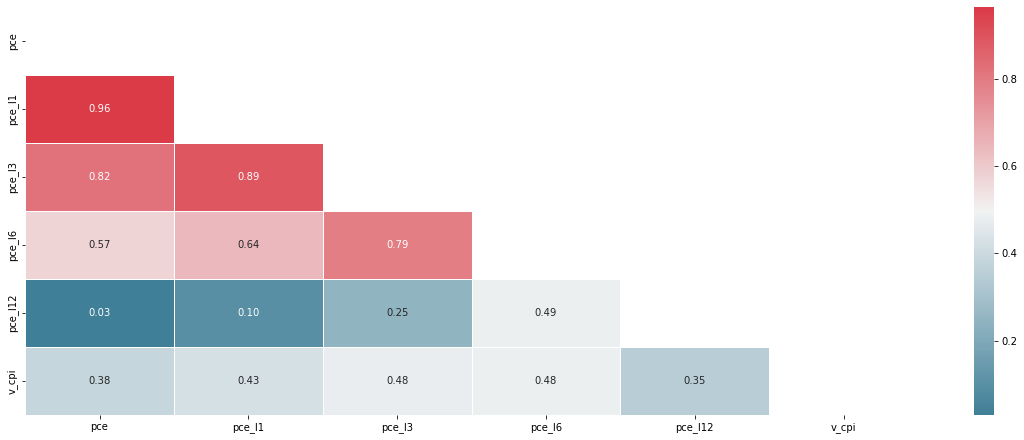

In [51]:
# Correlation matrix
corr_matrix = lags_inf[['pce','pce_l1','pce_l3','pce_l6','pce_l12','v_cpi']].copy()
corr = corr_matrix.corr()
fig, ax = plt.subplots(figsize=(20, 7.5))
colormap = sns.diverging_palette(225, 10, as_cmap = True)
dropvals = np.zeros_like(corr)
dropvals[np.triu_indices_from(dropvals)] = True
sns.heatmap(corr, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals)
plt.show()

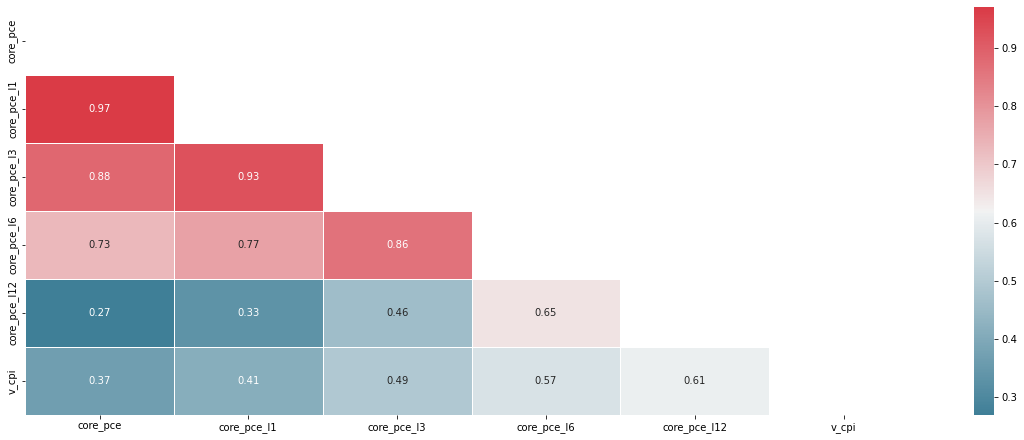

In [52]:
# Correlation matrix
corr_matrix = lags_inf[['core_pce','core_pce_l1','core_pce_l3','core_pce_l6','core_pce_l12','v_cpi']].copy()
corr = corr_matrix.corr()
fig, ax = plt.subplots(figsize=(20, 7.5))
colormap = sns.diverging_palette(225, 10, as_cmap = True)
dropvals = np.zeros_like(corr)
dropvals[np.triu_indices_from(dropvals)] = True
sns.heatmap(corr, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals)
plt.show()

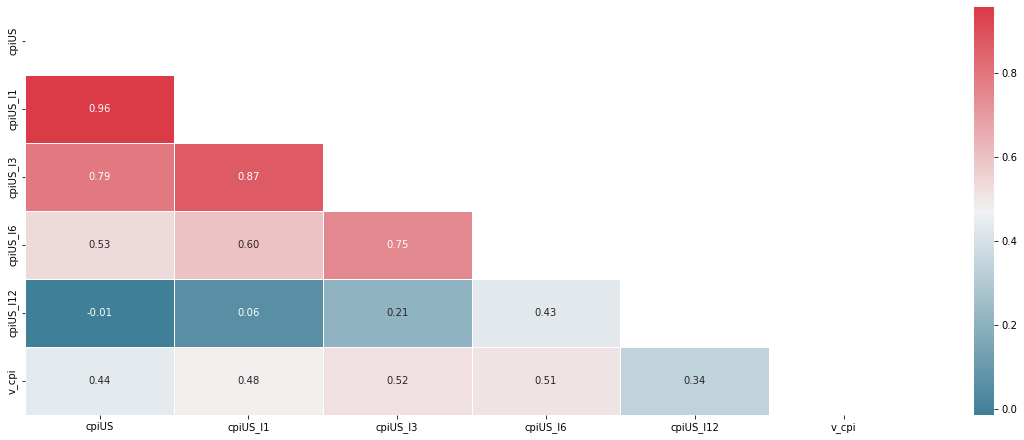

In [53]:
# Correlation matrix
corr_matrix = lags_inf[['cpiUS','cpiUS_l1','cpiUS_l3','cpiUS_l6','cpiUS_l12','v_cpi']].copy()
corr = corr_matrix.corr()
fig, ax = plt.subplots(figsize=(20, 7.5))
colormap = sns.diverging_palette(225, 10, as_cmap = True)
dropvals = np.zeros_like(corr)
dropvals[np.triu_indices_from(dropvals)] = True
sns.heatmap(corr, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals)
plt.show()

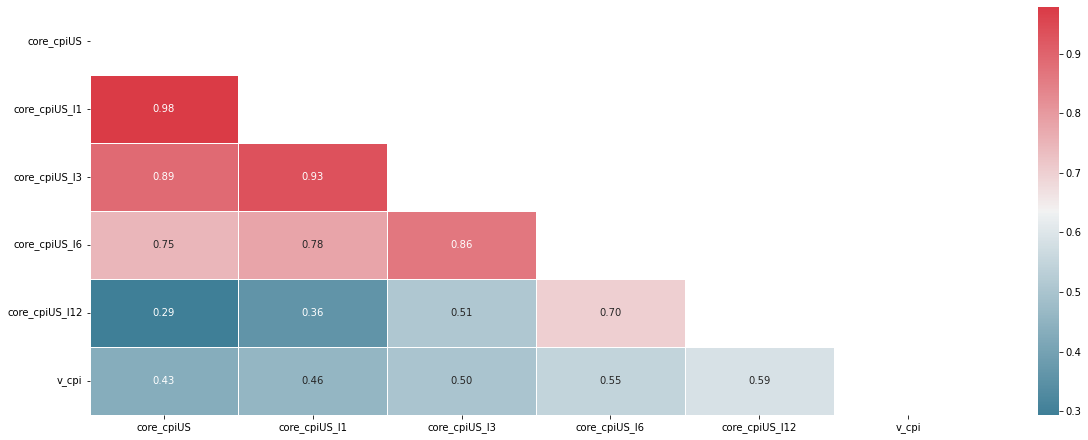

In [54]:
# Correlation matrix
corr_matrix = lags_inf[['core_cpiUS','core_cpiUS_l1','core_cpiUS_l3','core_cpiUS_l6','core_cpiUS_l12','v_cpi']].copy()
corr = corr_matrix.corr()
fig, ax = plt.subplots(figsize=(20, 7.5))
colormap = sns.diverging_palette(225, 10, as_cmap = True)
dropvals = np.zeros_like(corr)
dropvals[np.triu_indices_from(dropvals)] = True
sns.heatmap(corr, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals)
plt.show()

#### Mejor correlacion:
- Contemporanea: core_CPIUS y core_pce (0.66 y 0.56)
- core_cpiUS lag 12 (0.56)
- copre_pce lag 12 (0.60)

### Commodities

In [12]:
# Commodities (Petroleum, energy, food)
comm = pd.DataFrame()
#  Global price of Energy index (PNRGINDEXM)
comm['gpenergy'] = fred.get_series('PNRGINDEXM').pct_change(12)*100
#  Spot Crude Oil Price: West Texas Intermediate (WTI) (WTISPLC)
comm['pet_wti'] = fred.get_series('WTISPLC').pct_change(12)*100
# Food price Indexes
# Global price of Food index (PFOODINDEXM) (IMF)
comm['food_imf'] = fred.get_series('PFOODINDEXM').pct_change(12)*100
# FAO food price index
food = pd.read_csv('data/13072022/Food_price_indices_data_jul825.csv', delimiter=';')
food.index = pd.to_datetime(food.Date)#, format='%d/%m/%Y')
food = food.drop("Date", axis = 1)
comm['fao_Index'] = food['fao_Index'].pct_change(12)*100

comm['v_cpi'] = inf1['v_cpi']

comm.dropna(inplace=True)

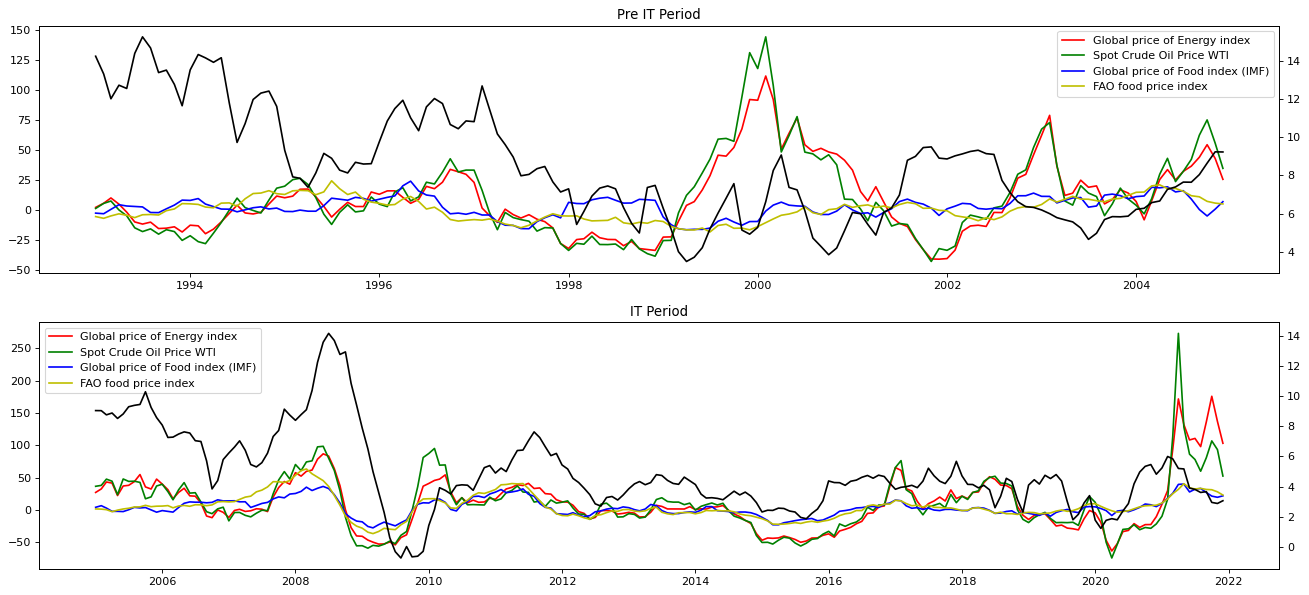

In [13]:
# plt.figure(figsize=(15,9), dpi= 80)

fig, axes = plt.subplots(2, 1, figsize=(20,9), dpi= 80)
axes[0].set_title('Pre IT Period')
ax2 = axes[0].twinx()
ax2.plot(comm['v_cpi'].loc['1992-01-01':'2004-12-01'], color='k',label='Guatemala')
axes[0].plot(comm['gpenergy'].loc['1992-01-01':'2004-12-01'], color='r',label='Global price of Energy index')
axes[0].plot(comm['pet_wti'].loc['1992-01-01':'2004-12-01'], color='g',label='Spot Crude Oil Price WTI')
axes[0].plot(comm['food_imf'].loc['1992-01-01':'2004-12-01'], color='b',label='Global price of Food index (IMF)')
axes[0].plot(comm['fao_Index'].loc['1992-01-01':'2004-12-01'], color='y',label='FAO food price index')
axes[0].legend()
# .loc['2005-01-01':'2021-12-01']
axes[1].set_title('IT Period')
ax3 = axes[1].twinx()
ax3.plot(comm['v_cpi'].loc['2005-01-01':'2021-12-01'], color='k',label='Guatemala')
axes[1].plot(comm['gpenergy'].loc['2005-01-01':'2021-12-01'], color='r',label='Global price of Energy index')
axes[1].plot(comm['pet_wti'].loc['2005-01-01':'2021-12-01'], color='g',label='Spot Crude Oil Price WTI')
axes[1].plot(comm['food_imf'].loc['2005-01-01':'2021-12-01'], color='b',label='Global price of Food index (IMF)')
axes[1].plot(comm['fao_Index'].loc['2005-01-01':'2021-12-01'], color='y',label='FAO food price index')
axes[1].legend()

plt.show()

#### Correlation with Commodities proxys

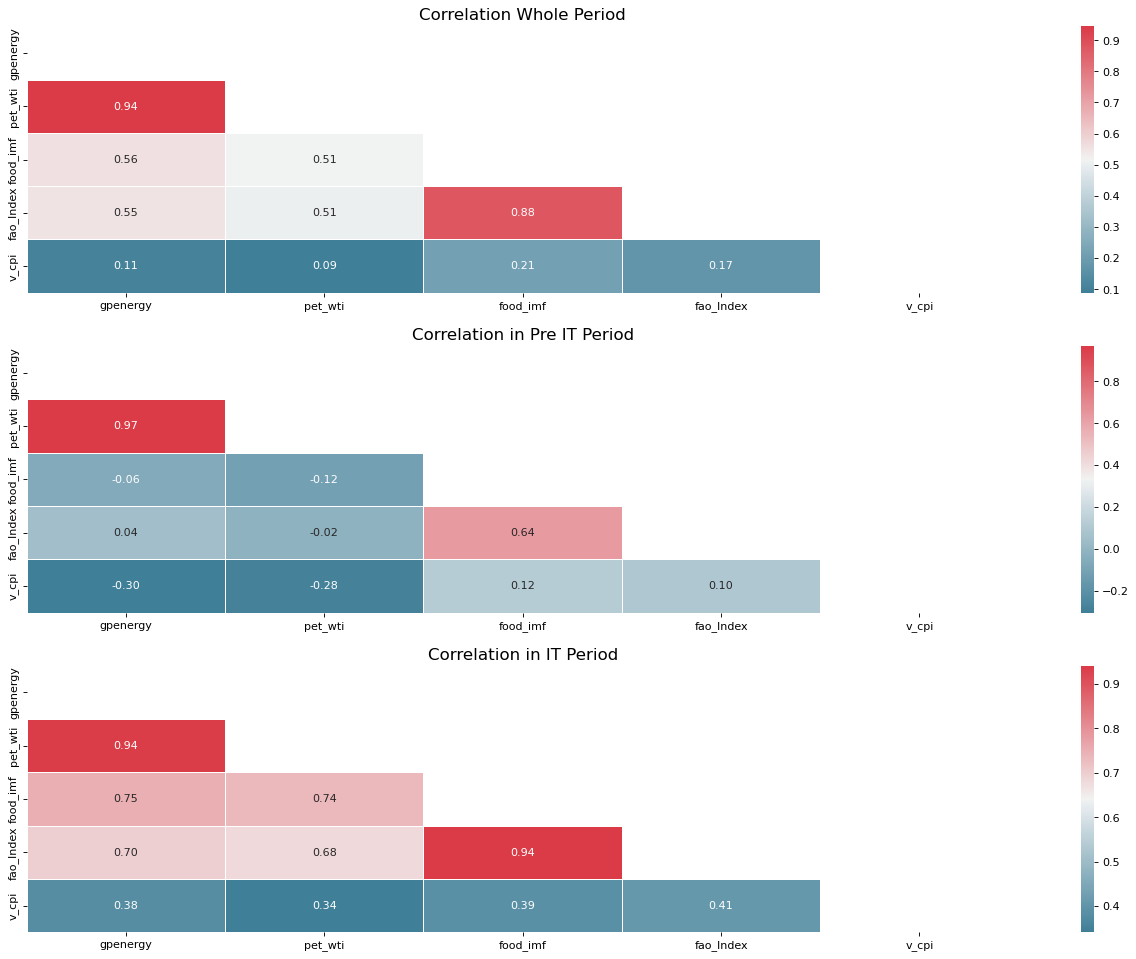

In [14]:
# Correlation matrix
corr = comm[['gpenergy','pet_wti','food_imf','fao_Index', 'v_cpi' ]].corr()
corr1 = comm[['gpenergy','pet_wti','food_imf','fao_Index', 'v_cpi' ]].loc['1992-01-01':'2004-12-01'].corr()
corr2 = comm[['gpenergy','pet_wti','food_imf','fao_Index', 'v_cpi' ]].loc['2005-01-01':'2021-12-01'].corr()

# fig, ax = plt.subplots(figsize=(20, 7.5))
colormap = sns.diverging_palette(225, 10, as_cmap = True)
dropvals = np.zeros_like(corr)
dropvals[np.triu_indices_from(dropvals)] = True

fig, axes = plt.subplots(3, 1, figsize=(20,15), dpi= 80)
sns.heatmap(corr, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[0])
axes[0].set_title('Correlation Whole Period',fontsize=15)
sns.heatmap(corr1, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[1])
axes[1].set_title('Correlation in Pre IT Period',fontsize=15)
sns.heatmap(corr2, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[2])
axes[2].set_title('Correlation in IT Period', fontsize=15)
plt.show()

#### Correlation with Commodities proxys lags

In [56]:
# lag creation
lags_comm = pd.DataFrame()
# Global price of Energy index (PNRGINDEXM)
lags_comm["gpenergy_l1"] = comm['gpenergy'].shift().loc['1993-01-01':]
lags_comm["gpenergy_l3"] = comm['gpenergy'].shift(3).loc['1993-01-01':]
lags_comm["gpenergy_l6"] = comm['gpenergy'].shift(6).loc['1993-01-01':]
lags_comm["gpenergy_l9"] = comm['gpenergy'].shift(9).loc['1993-01-01':]
lags_comm["gpenergy_l12"] = comm['gpenergy'].shift(12).loc['1993-01-01':]

#  Spot Crude Oil Price: West Texas Intermediate (WTI) (WTISPLC)
lags_comm["pet_wti_l1"] = comm['pet_wti'].shift().loc['1993-01-01':]
lags_comm["pet_wti_l3"] = comm['pet_wti'].shift(3).loc['1993-01-01':]
lags_comm["pet_wti_l6"] = comm['pet_wti'].shift(6).loc['1993-01-01':]
lags_comm["pet_wti_l9"] = comm['pet_wti'].shift(9).loc['1993-01-01':]
lags_comm["pet_wti_l12"] = comm['pet_wti'].shift(12).loc['1993-01-01':]

# Global price of Food index (PFOODINDEXM) (IMF)
lags_comm["food_imf_l1"] = comm['food_imf'].shift().loc['1993-01-01':]
lags_comm["food_imf_l3"] = comm['food_imf'].shift(3).loc['1993-01-01':]
lags_comm["food_imf_l6"] = comm['food_imf'].shift(6).loc['1993-01-01':]
lags_comm["food_imf_l9"] = comm['food_imf'].shift(9).loc['1993-01-01':]
lags_comm["food_imf_l12"] = comm['food_imf'].shift(12).loc['1993-01-01':]


# FAO food Index
lags_comm["fao_Index_l1"] = comm['fao_Index'].shift().loc['1993-01-01':]
lags_comm["fao_Index_l3"] = comm['fao_Index'].shift(3).loc['1993-01-01':]
lags_comm["fao_Index_l6"] = comm['fao_Index'].shift(6).loc['1993-01-01':]
lags_comm["fao_Index_l9"] = comm['fao_Index'].shift(9).loc['1993-01-01':]
lags_comm["fao_Index_l12"] = comm['fao_Index'].shift(12).loc['1993-01-01':]


lags_comm['v_cpi'] = inf1['v_cpi'].loc['1993-01-01':]
lags_comm['gpenergy'] = comm['gpenergy'].loc['1993-01-01':]
lags_comm['pet_wti'] = comm['pet_wti'].loc['1993-01-01':]
lags_comm['food_imf'] = comm['food_imf'].loc['1993-01-01':]
lags_comm['fao_Index'] = comm['fao_Index'].loc['1993-01-01':]

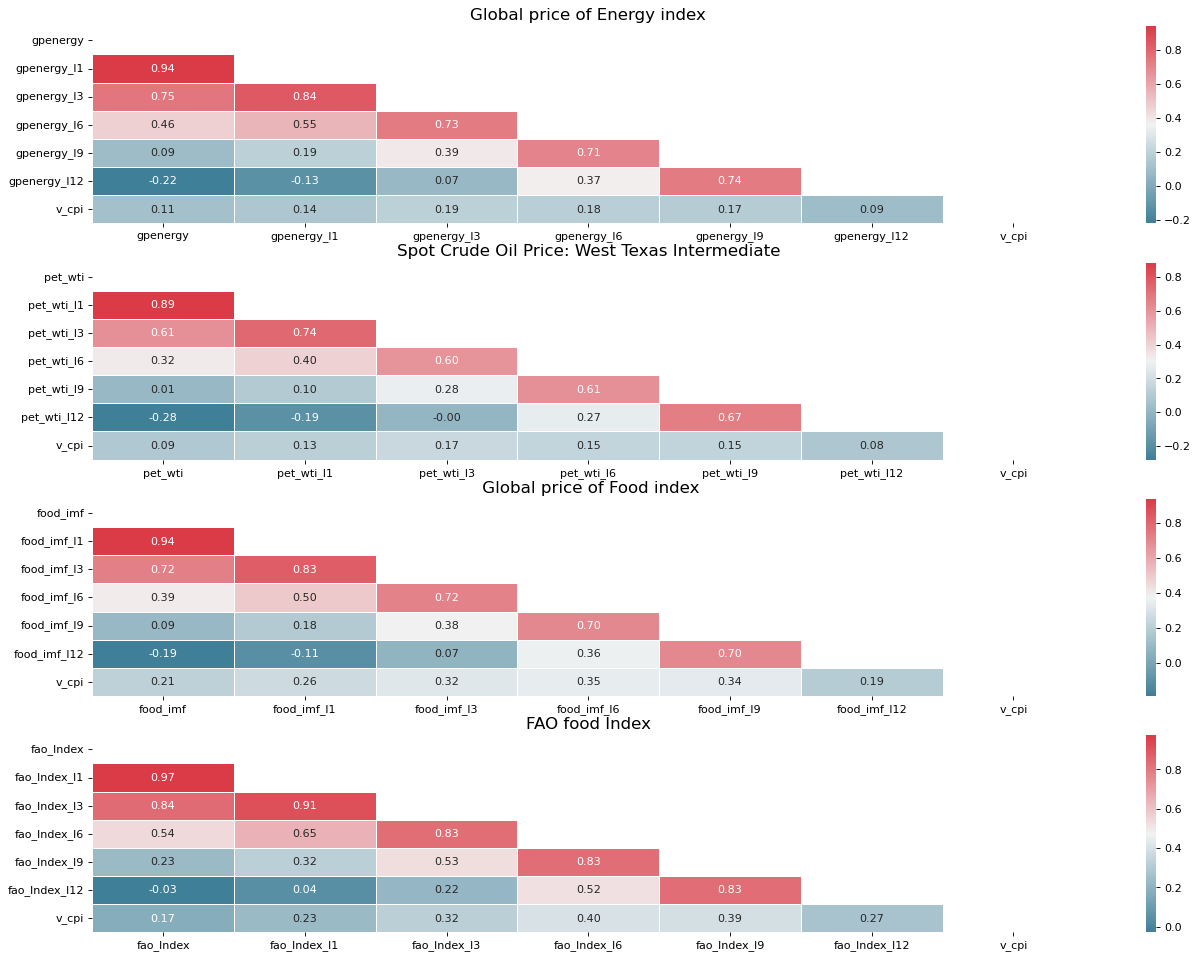

In [57]:
# Correlation matrix
corr1 = lags_comm[['gpenergy','gpenergy_l1','gpenergy_l3','gpenergy_l6','gpenergy_l9','gpenergy_l12', 'v_cpi']].corr()
corr2 = lags_comm[['pet_wti', 'pet_wti_l1','pet_wti_l3','pet_wti_l6','pet_wti_l9', 'pet_wti_l12','v_cpi' ]].corr()
corr3 = lags_comm[['food_imf','food_imf_l1','food_imf_l3','food_imf_l6','food_imf_l9','food_imf_l12', 'v_cpi' ]].corr()
corr4 = lags_comm[['fao_Index','fao_Index_l1','fao_Index_l3','fao_Index_l6','fao_Index_l9','fao_Index_l12', 'v_cpi' ]].corr()

# fig, ax = plt.subplots(figsize=(20, 7.5))
colormap = sns.diverging_palette(225, 10, as_cmap = True)
dropvals = np.zeros_like(corr1)
dropvals[np.triu_indices_from(dropvals)] = True

fig, axes = plt.subplots(4, 1, figsize=(20,15), dpi= 80)
sns.heatmap(corr1, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[0])
axes[0].set_title('Global price of Energy index',fontsize=15)
sns.heatmap(corr2, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[1])
axes[1].set_title('Spot Crude Oil Price: West Texas Intermediate',fontsize=15)
sns.heatmap(corr3, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[2])
axes[2].set_title(' Global price of Food index', fontsize=15)
sns.heatmap(corr4, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[3])
axes[3].set_title('FAO food Index', fontsize=15)
plt.show()

Mejor correlacion:
- Contemporaneas
  - fao_index (0.41) (IT period)
  - gpenergy (0.38) (IT period)
  - food_fmi (0.21) (complete period)

- Lags:
  - fao_index lago 6 (0.40)

### External Economic Activity

In [34]:

# Economic Activity
econ = pd.DataFrame()
#  Index of Global Real Economic Activity (IGREA) (FED Dallas)
# STARTS IN  1968-01-01
IGREA = fred.get_series('IGREA')
econ['IGREA'] = (IGREA - np.mean(IGREA)) / np.std(IGREA)

#  Coincident Economic Activity Index for the United States (USPHCI) (FED philladelphia)
# STARTS IN 1979-01-01
econ['USPHCI'] = fred.get_series('USPHCI').pct_change(12)*100

#  Global Economic Policy Uncertainty Index: Current Price Adjusted GDP (GEPUCURRENT) (1997-2021)
# starts in 1997-01-01
# GEPUCURRENT = fred.get_series('GEPUCURRENT')
# econ['GEPUI'] = (GEPUCURRENT - np.mean(GEPUCURRENT)) / np.std(GEPUCURRENT)#.pct_change(12)

# Leading Indicators OECD: Reference series: Gross Domestic Product (GDP): 
# Normalised for the United States (USALORSGPNOSTSAM)
# starts in 1960-01-01
econ['mgdp_us'] = fred.get_series('USALORSGPNOSTSAM').pct_change(12)*100

##### Index of Global Real Economic Activity

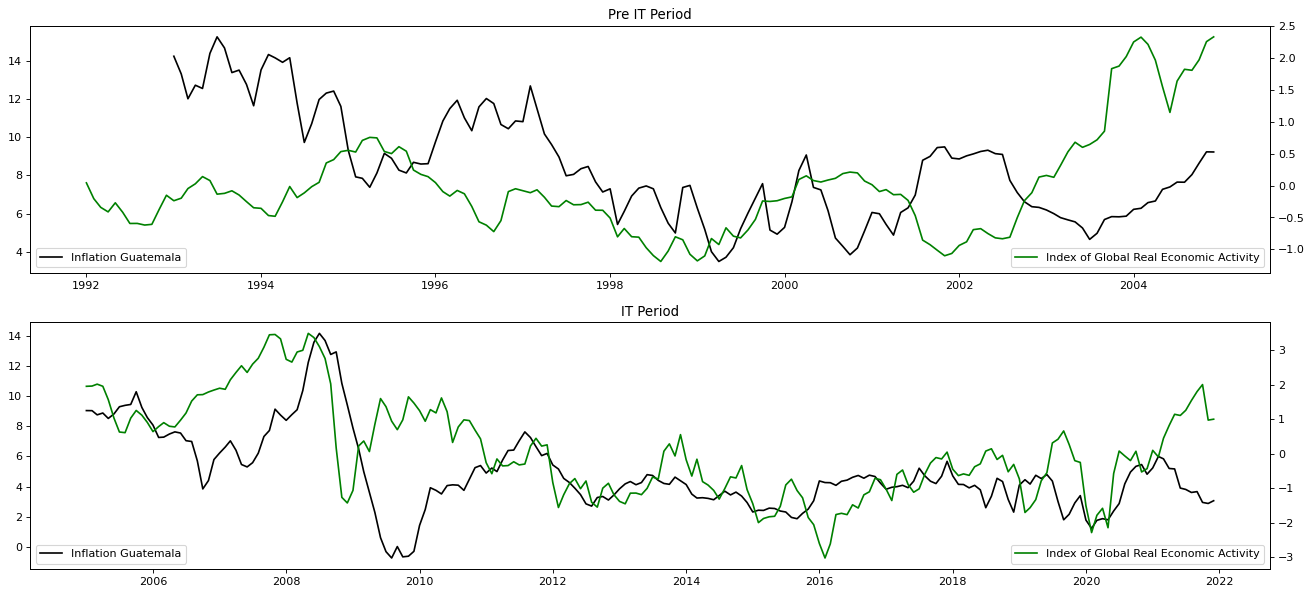

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(20,9), dpi= 80)
axes[0].set_title('Pre IT Period')
ax2 = axes[0].twinx()
axes[0].plot(comm['v_cpi'].loc['1992-01-01':'2004-12-01'], color='k',label='Inflation Guatemala')
ax2.plot(econ['IGREA'].loc['1992-01-01':'2004-12-01'], color='g',label='Index of Global Real Economic Activity')
axes[0].legend(loc=3)
ax2.legend(loc=4)
axes[1].set_title('IT Period')
ax3 = axes[1].twinx()
axes[1].plot(comm['v_cpi'].loc['2005-01-01':'2021-12-01'], color='k',label='Inflation Guatemala')
ax3.plot(econ['IGREA'].loc['2005-01-01':'2021-12-01'], color='g',label='Index of Global Real Economic Activity')
axes[1].legend(loc=3)
ax3.legend(loc=4)

plt.show()

##### Coincident Economic Activity Index for the United States (USPHCI) (FED philladelphia)

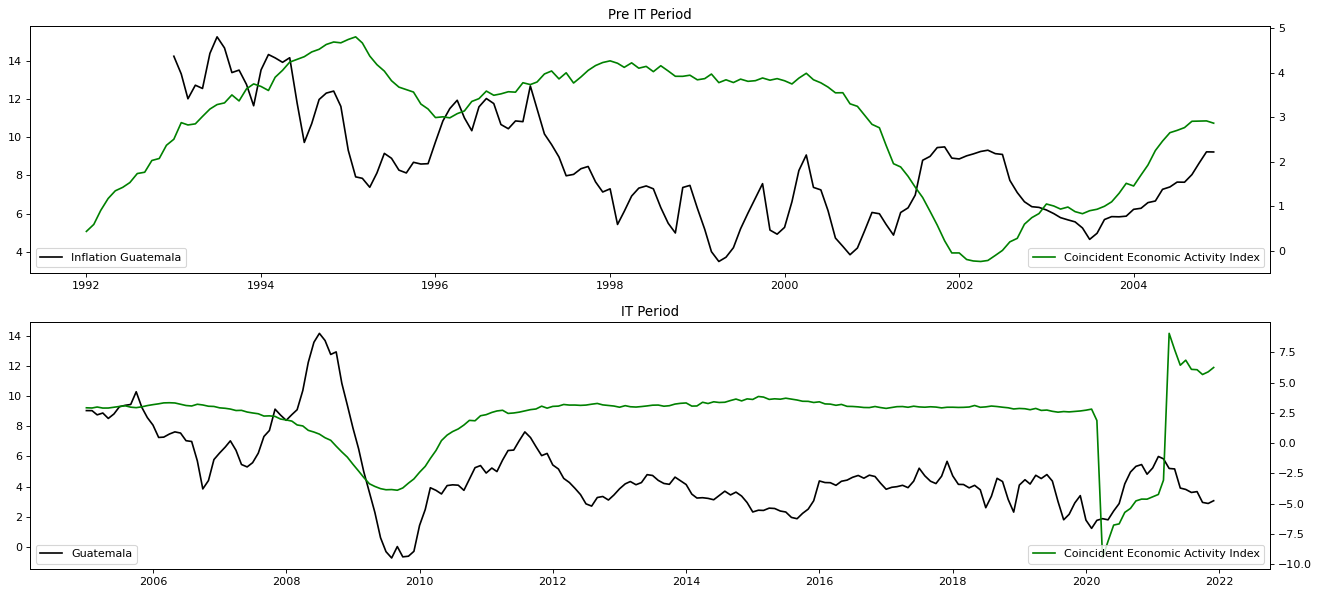

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(20,9), dpi= 80)
axes[0].set_title('Pre IT Period')
ax2 = axes[0].twinx()
axes[0].plot(comm['v_cpi'].loc['1992-01-01':'2004-12-01'], color='k',label='Inflation Guatemala')
ax2.plot(econ['USPHCI'].loc['1992-01-01':'2004-12-01'], color='g',label='Coincident Economic Activity Index')
axes[0].legend(loc=3)
ax2.legend(loc=4)
axes[1].set_title('IT Period')
ax3 = axes[1].twinx()
axes[1].plot(comm['v_cpi'].loc['2005-01-01':'2021-12-01'], color='k',label='Guatemala')
ax3.plot(econ['USPHCI'].loc['2005-01-01':'2021-12-01'], color='g',label='Coincident Economic Activity Index')
axes[1].legend(loc=3)
ax3.legend(loc=4)

plt.show()

##### Gross Domestic Product (GDP): Normalised for the United States OECD

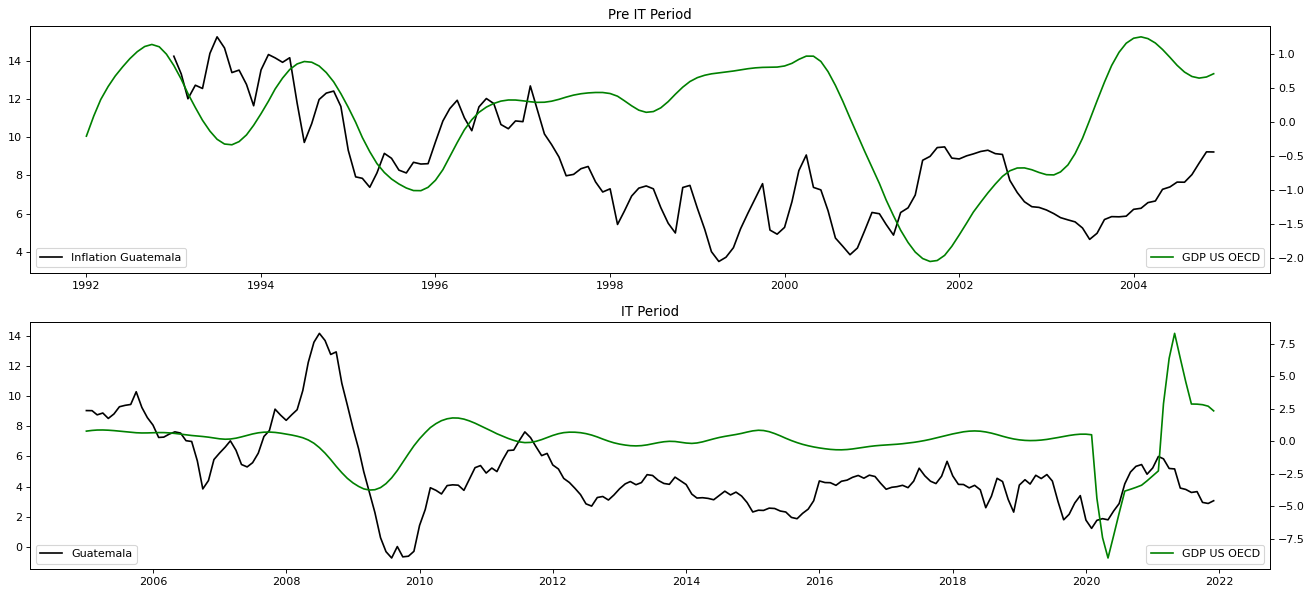

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(20,9), dpi= 80)
axes[0].set_title('Pre IT Period')
ax2 = axes[0].twinx()
axes[0].plot(comm['v_cpi'].loc['1992-01-01':'2004-12-01'], color='k',label='Inflation Guatemala')
ax2.plot(econ['mgdp_us'].loc['1992-01-01':'2004-12-01'], color='g',label='GDP US OECD')
axes[0].legend(loc=3)
ax2.legend(loc=4)
axes[1].set_title('IT Period')
ax3 = axes[1].twinx()
axes[1].plot(comm['v_cpi'].loc['2005-01-01':'2021-12-01'], color='k',label='Guatemala')
ax3.plot(econ['mgdp_us'].loc['2005-01-01':'2021-12-01'], color='g',label='GDP US OECD')
axes[1].legend(loc=3)
ax3.legend(loc=4)

plt.show()

#### Correlation Matrix with External Economic Activity

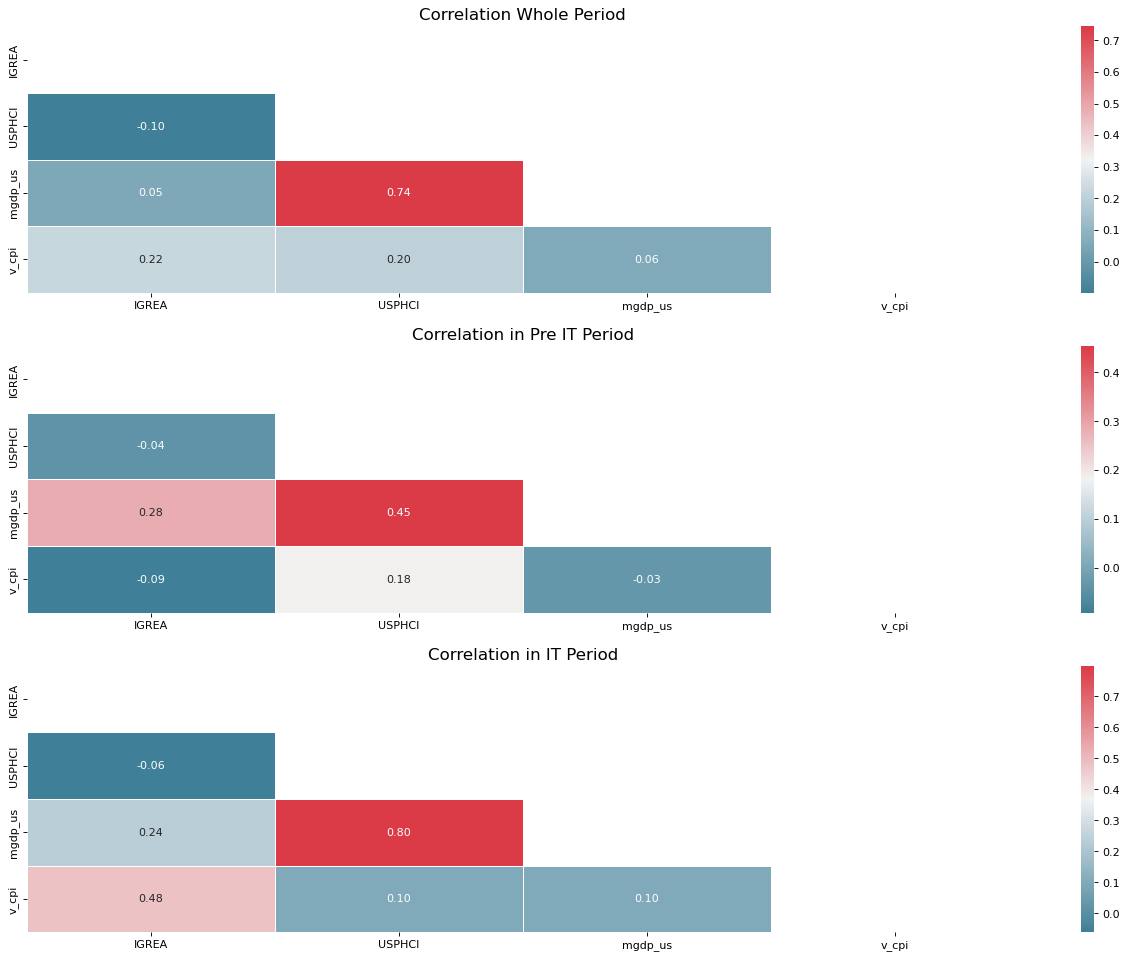

In [37]:
# Correlation matrix
econ['v_cpi'] = comm['v_cpi']
corr = econ[['IGREA','USPHCI', 'mgdp_us','v_cpi' ]].corr()
corr1 = econ[['IGREA','USPHCI', 'mgdp_us','v_cpi' ]].loc['1992-01-01':'2004-12-01'].corr()
corr2 = econ[['IGREA','USPHCI', 'mgdp_us','v_cpi' ]].loc['2005-01-01':'2021-12-01'].corr()

# fig, ax = plt.subplots(figsize=(20, 7.5))
colormap = sns.diverging_palette(225, 10, as_cmap = True)
dropvals = np.zeros_like(corr)
dropvals[np.triu_indices_from(dropvals)] = True

fig, axes = plt.subplots(3, 1, figsize=(20,15), dpi= 80)
sns.heatmap(corr, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[0])
axes[0].set_title('Correlation Whole Period',fontsize=15)
sns.heatmap(corr1, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[1])
axes[1].set_title('Correlation in Pre IT Period',fontsize=15)
sns.heatmap(corr2, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[2])
axes[2].set_title('Correlation in IT Period', fontsize=15)
plt.show()

#### Correlation with economic activity proxys lags

In [61]:
# lag creation
lags_econ = pd.DataFrame()
# Global price of Energy index (PNRGINDEXM)
lags_econ["IGREA_l1"] = econ['IGREA'].shift().loc['1993-01-01':]
lags_econ["IGREA_l3"] = econ['IGREA'].shift(3).loc['1993-01-01':]
lags_econ["IGREA_l6"] = econ['IGREA'].shift(6).loc['1993-01-01':]
lags_econ["IGREA_l9"] = econ['IGREA'].shift(9).loc['1993-01-01':]
lags_econ["IGREA_l12"] = econ['IGREA'].shift(12).loc['1993-01-01':]

#  Spot Crude Oil Price: West Texas Intermediate (WTI) (WTISPLC)
lags_econ["USPHCI_l1"] = econ['USPHCI'].shift().loc['1993-01-01':]
lags_econ["USPHCI_l3"] = econ['USPHCI'].shift(3).loc['1993-01-01':]
lags_econ["USPHCI_l6"] = econ['USPHCI'].shift(6).loc['1993-01-01':]
lags_econ["USPHCI_l9"] = econ['USPHCI'].shift(9).loc['1993-01-01':]
lags_econ["USPHCI_l12"] = econ['USPHCI'].shift(12).loc['1993-01-01':]

# Global price of Food index (PFOODINDEXM) (IMF)
lags_econ["mgdp_us_l1"] = econ['mgdp_us'].shift().loc['1993-01-01':]
lags_econ["mgdp_us_l3"] = econ['mgdp_us'].shift(3).loc['1993-01-01':]
lags_econ["mgdp_us_l6"] = econ['mgdp_us'].shift(6).loc['1993-01-01':]
lags_econ["mgdp_us_l9"] = econ['mgdp_us'].shift(9).loc['1993-01-01':]
lags_econ["mgdp_us_l12"] = econ['mgdp_us'].shift(12).loc['1993-01-01':]

lags_econ['v_cpi'] = inf1['v_cpi'].loc['1993-01-01':]
lags_econ['IGREA'] = econ['IGREA'].loc['1993-01-01':]
lags_econ['USPHCI'] = econ['USPHCI'].loc['1993-01-01':]
lags_econ['mgdp_us'] = econ['mgdp_us'].loc['1993-01-01':]

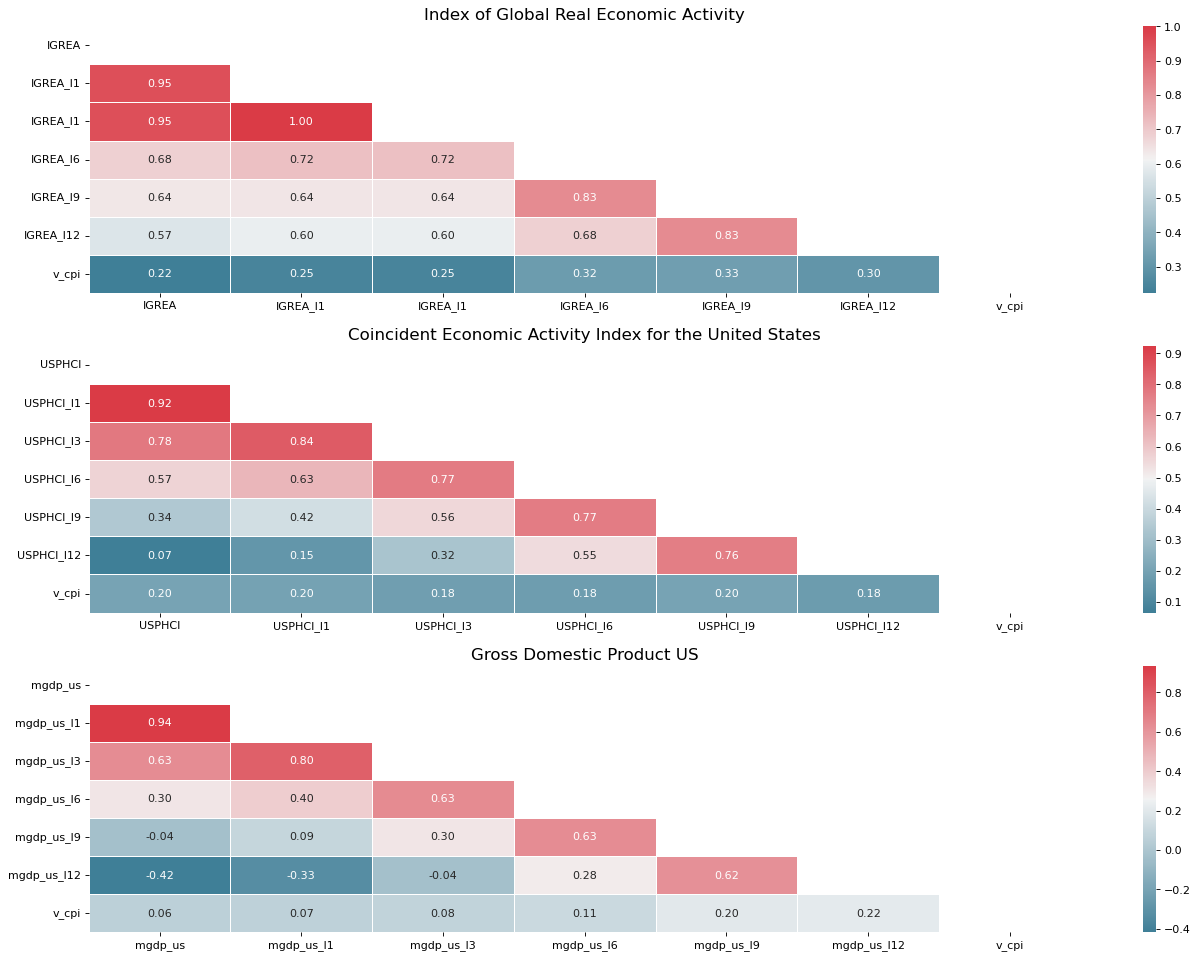

In [65]:
# Correlation matrix
corr1 = lags_econ[['IGREA','IGREA_l1','IGREA_l1','IGREA_l6','IGREA_l9','IGREA_l12', 'v_cpi']].corr()
corr2 = lags_econ[['USPHCI', 'USPHCI_l1','USPHCI_l3','USPHCI_l6','USPHCI_l9', 'USPHCI_l12','v_cpi' ]].corr()
corr3 = lags_econ[['mgdp_us','mgdp_us_l1','mgdp_us_l3','mgdp_us_l6','mgdp_us_l9','mgdp_us_l12', 'v_cpi' ]].corr()

# fig, ax = plt.subplots(figsize=(20, 7.5))
colormap = sns.diverging_palette(225, 10, as_cmap = True)
dropvals = np.zeros_like(corr1)
dropvals[np.triu_indices_from(dropvals)] = True

fig, axes = plt.subplots(3, 1, figsize=(20,15), dpi= 80)
sns.heatmap(corr1, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[0])
axes[0].set_title('Index of Global Real Economic Activity',fontsize=15)
sns.heatmap(corr2, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[1])
axes[1].set_title('Coincident Economic Activity Index for the United States',fontsize=15)
sns.heatmap(corr3, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[2])
axes[2].set_title('Gross Domestic Product US', fontsize=15)
plt.show()

Best correlation:
- IGREA LAG 9, 6 AND 12 (0.33, 0.32 AND 0.30)
- MGDP_US LAG 12 (0.22)

### Import/Export Prices for the US

In [21]:
pr = pd.DataFrame()
pr['imp_us'] = fred.get_series('IR').pct_change(12)*100
pr['exp_us'] = fred.get_series('IQ').pct_change(12)*100
pr['v_cpi'] = comm['v_cpi']

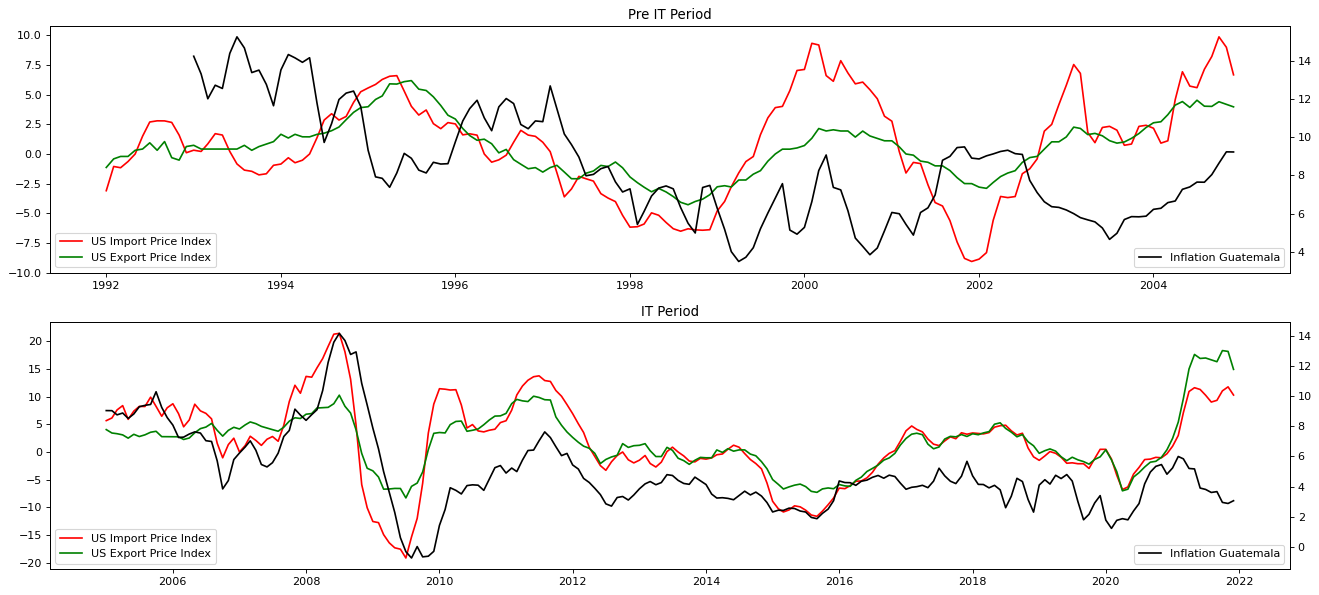

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(20,9), dpi= 80)
axes[0].set_title('Pre IT Period')
ax2 = axes[0].twinx()
ax2.plot(pr['v_cpi'].loc['1992-01-01':'2004-12-01'], color='k',label='Inflation Guatemala')
axes[0].plot(pr['imp_us'].loc['1992-01-01':'2004-12-01'], color='r',label='US Import Price Index')
axes[0].plot(pr['exp_us'].loc['1992-01-01':'2004-12-01'], color='g',label='US Export Price Index')
axes[0].legend(loc=3)
ax2.legend(loc=4)

axes[1].set_title('IT Period')
ax3 = axes[1].twinx()
ax3.plot(pr['v_cpi'].loc['2005-01-01':'2021-12-01'], color='k',label='Inflation Guatemala')
axes[1].plot(pr['imp_us'].loc['2005-01-01':'2021-12-01'], color='r',label='US Import Price Index')
axes[1].plot(pr['exp_us'].loc['2005-01-01':'2021-12-01'], color='g',label='US Export Price Index')
axes[1].legend(loc=3)
ax3.legend(loc=4)

#### Correlation with Import and Export US Prices

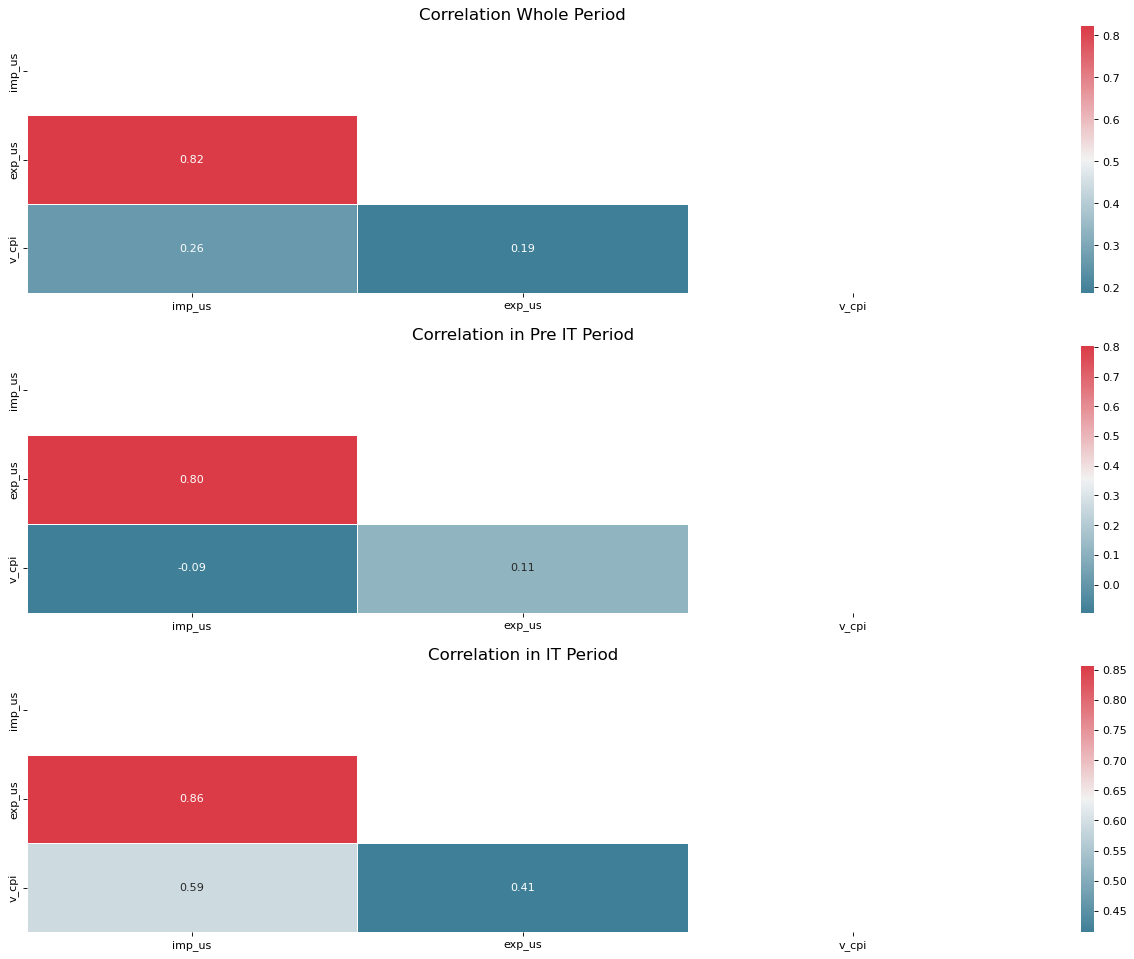

In [23]:
# Correlation matrix
corr = pr[['imp_us','exp_us', 'v_cpi' ]].corr()
corr1 = pr[['imp_us','exp_us', 'v_cpi' ]].loc['1992-01-01':'2004-12-01'].corr()
corr2 = pr[['imp_us','exp_us', 'v_cpi' ]].loc['2005-01-01':'2021-12-01'].corr()

# fig, ax = plt.subplots(figsize=(20, 7.5))
colormap = sns.diverging_palette(225, 10, as_cmap = True)
dropvals = np.zeros_like(corr)
dropvals[np.triu_indices_from(dropvals)] = True

fig, axes = plt.subplots(3, 1, figsize=(20,15), dpi= 80)
sns.heatmap(corr, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[0])
axes[0].set_title('Correlation Whole Period',fontsize=15)
sns.heatmap(corr1, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[1])
axes[1].set_title('Correlation in Pre IT Period',fontsize=15)
sns.heatmap(corr2, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[2])
axes[2].set_title('Correlation in IT Period', fontsize=15)
plt.show()

#### Correlation with import/export prices proxys lags

In [24]:
# lag creation
lags_pr = pd.DataFrame()
# Global price of Energy index (PNRGINDEXM)
lags_pr["imp_us_l1"] = pr['imp_us'].shift()
lags_pr["imp_us_l3"] = pr['imp_us'].shift(3)
lags_pr["imp_us_l6"] = pr['imp_us'].shift(6)
lags_pr["imp_us_l9"] = pr['imp_us'].shift(9)
lags_pr["imp_us_l12"] = pr['imp_us'].shift(12)

#  Spot Crude Oil Price: West Texas Intermediate (WTI) (WTISPLC)
lags_pr["exp_us_l1"] = pr['exp_us'].shift()
lags_pr["exp_us_l3"] = pr['exp_us'].shift(3)
lags_pr["exp_us_l6"] = pr['exp_us'].shift(6)
lags_pr["exp_us_l9"] = pr['exp_us'].shift(9)
lags_pr["exp_us_l12"] = pr['exp_us'].shift(12)

lags_pr['v_cpi'] = pr['v_cpi']
lags_pr['imp_us'] = pr['imp_us']
lags_pr['exp_us'] = pr['exp_us']

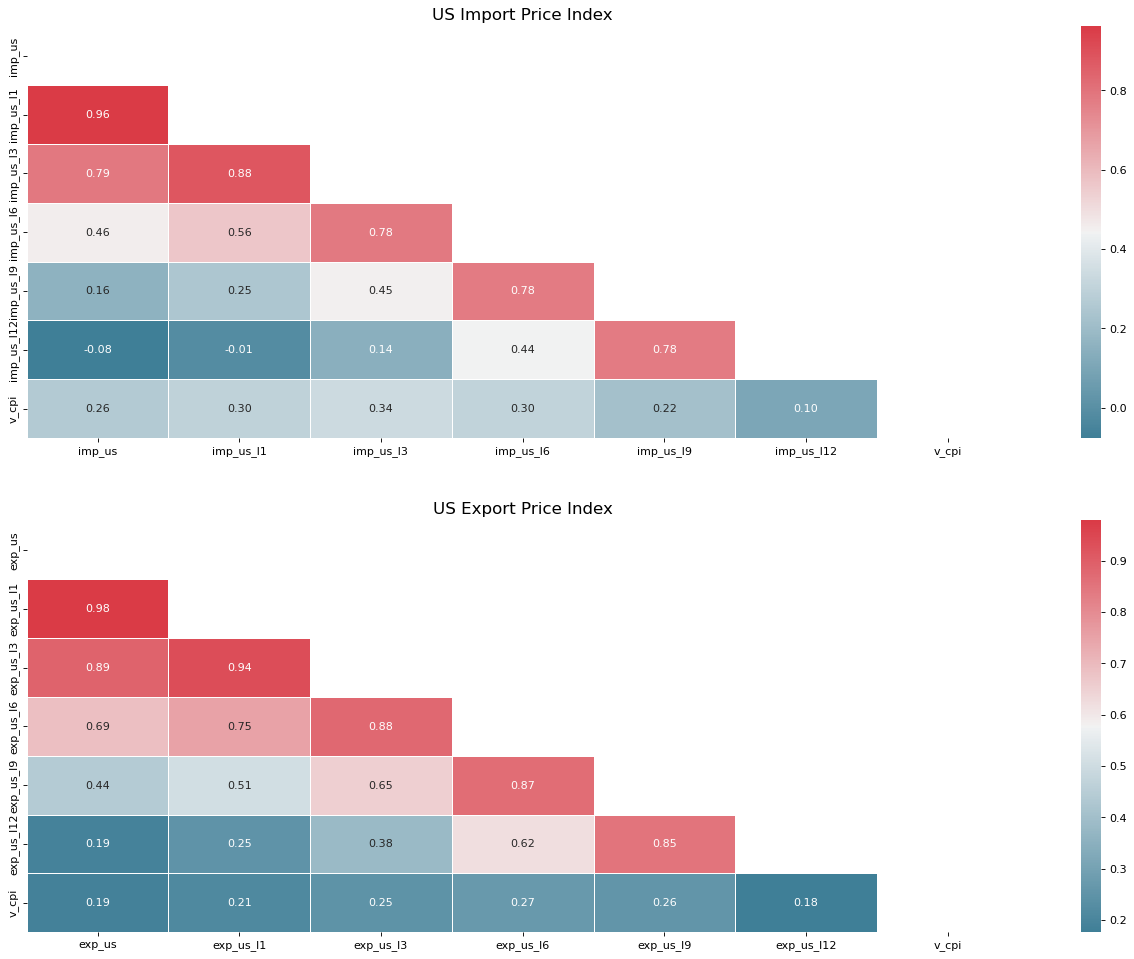

In [25]:
# Correlation matrix
corr1 = lags_pr[['imp_us', 'imp_us_l1','imp_us_l3','imp_us_l6','imp_us_l9','imp_us_l12', 'v_cpi']].corr()
corr2 = lags_pr[['exp_us', 'exp_us_l1','exp_us_l3','exp_us_l6','exp_us_l9', 'exp_us_l12','v_cpi' ]].corr()

# fig, ax = plt.subplots(figsize=(20, 7.5))
colormap = sns.diverging_palette(225, 10, as_cmap = True)
dropvals = np.zeros_like(corr1)
dropvals[np.triu_indices_from(dropvals)] = True

fig, axes = plt.subplots(2, 1, figsize=(20,15), dpi= 80)
sns.heatmap(corr1, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[0])
axes[0].set_title('US Import Price Index',fontsize=15)
sns.heatmap(corr2, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals, ax=axes[1])
axes[1].set_title('US Export Price Index',fontsize=15)
plt.show()

### Databases

##### Base: contemporary data with best controls

In [42]:
# Base Controls
controls = pd.DataFrame()
# External Inflation: Core CPI Inflation
controls['core_cpiUS'] = infE['core_cpiUS']

# Commodities
# Global price of Energy index (Source: IMF)
controls['energy'] = comm['gpenergy']
# IMF Food Index(Source: IMF)
controls['food'] =comm['food_imf']

# External Activity
# Index of Global Real Economic Activity
controls['ext_gdp'] = econ['IGREA']

# US Import prices
# Import Price Index (End Use) BLS
controls['imp_us'] = pr['imp_us']

controls = controls.loc['1993-01-01':'2021-12-01']
controls.head()

,core_cpiUS,energy,food,ext_gdp,imp_us
1993-01-01,3.445899,2.258751,-2.526322,-0.237275,0.319149
1993-02-01,3.576341,5.714395,-3.016986,-0.197205,0.212766
1993-03-01,3.358465,10.127442,0.614148,-0.046593,0.851970
1993-04-01,3.485988,4.956868,4.504585,0.028151,1.709402
1993-05-01,3.405995,-1.703107,3.413075,0.140938,1.595745


In [43]:
controls.to_csv('output/controls_base.csv', sep=';')

##### Lags db: best lags/best controls

In [82]:
lagged = pd.DataFrame()

# External Inflation
# Core PCE Inflation lag 12
lagged['core_pce_l12'] = lags_inf["core_pce_l12"]

# Commodities
# Global price of Energy index lag 3
lagged['energy_l3'] = lags_comm["gpenergy_l3"]
# Food FAO lag 6
temp = food['fao_Index'].pct_change(12)*100
lagged['fao_Index_l6'] = temp.shift(6)

# External Activity
# Index of Global Real Economic Activity
lagged['ext_gdp_l12'] = lags_econ["IGREA_l12"]

# US Import prices
# Import Price Index (End Use) BLS
lagged['imp_us_l3'] = lags_pr["imp_us_l3"]

lagged.dropna(inplace=True)
lagged.shape

(345, 5)

In [83]:
lagged.to_csv('output/controls_lagged.csv', sep=';')

##### Internal controls (Not used)

In [29]:
# Controls guatemala
# other_gt = pd.read_csv('data/13072022/other_gt.csv', delimiter=';')
# other_gt.index = pd.to_datetime(other_gt.Date, format='%d/%m/%Y')
# other_gt = other_gt.drop("Date", axis = 1)
# other_gt['ner_gt'] = other_gt['ner_gt'].pct_change(12)*100
# other_gt['omas_mn'] = other_gt['omas_mn'].pct_change(12)*100
# other_gt['emision'] = other_gt['emision'].pct_change(12)*100
# cont['ner_gt'] = other_gt['ner_gt'].loc['1993-01-01':'2021-12-01']
# cont['omas_mn'] = other_gt['omas_mn'].loc['1993-01-01':'2021-12-01']
# cont['emision'] = other_gt['emision'].loc['1993-01-01':'2021-12-01']

# cont2 = cont.dropna()